Before we start training process you should change runtime type.
1. Click to Runtime --> Change runtime type.
2. Choose "T4 GPU" and save it.

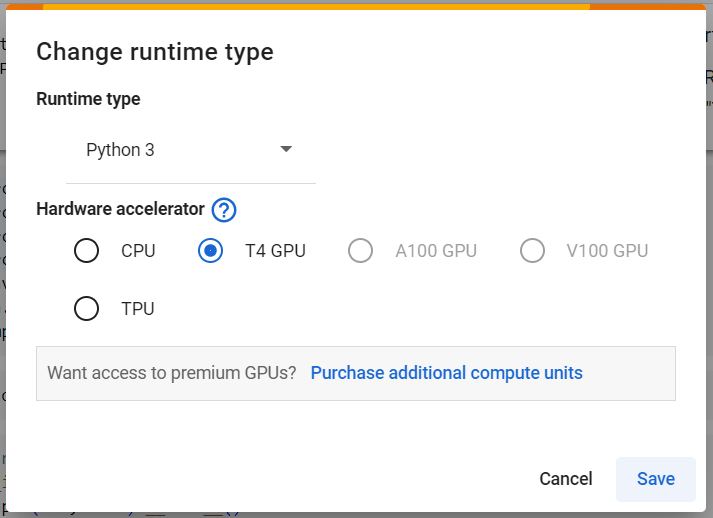

3. Upload test images to colab

In [ ]:
!pip install transformers

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from matplotlib import pyplot as plt
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTConfig

from torch.utils.data import Subset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 64

In [ ]:
transform = transforms.Compose(
     [transforms.Resize(224),
      transforms.ToTensor()])


In [ ]:

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./cifar', train=False, download=True, transform=transform)

# Define the number of samples you want for training and testing
train_subset_size = 6000
test_subset_size = 2000

# Create subsets of the datasets
train_subset = Subset(trainset, list(range(train_subset_size)))
test_subset = Subset(testset, list(range(test_subset_size)))

# Create data loaders for the subsets
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

# Print the number of samples in the subsets
print(len(train_subset))
print(len(test_subset))


Files already downloaded and verified
Files already downloaded and verified
6000
2000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
num_classes = 10

# Load the pre-trained ViT model and feature extractor
model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
config = ViTConfig.from_pretrained(model_name)
model = ViTForImageClassification(config)

# Modify the classification head
model.classifier = torch.nn.Linear(in_features=model.config.hidden_size, out_features=num_classes)
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs).logits
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs).logits
            test_loss += criterion(output, labels).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [ ]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)
    torch.save(model.state_dict(), 'cifar_vit_model.pth')
    print('model saved')

Train Epoch: 1 [0/6000 (0%)]	Loss: 2.349126

Test set: Average loss: 0.0389, Accuracy: 198/2000 (9.90%)

model saved
Train Epoch: 2 [0/6000 (0%)]	Loss: 2.478743

Test set: Average loss: 0.0376, Accuracy: 203/2000 (10.15%)

model saved
Train Epoch: 3 [0/6000 (0%)]	Loss: 2.356644

Test set: Average loss: 0.0370, Accuracy: 217/2000 (10.85%)

model saved
Train Epoch: 4 [0/6000 (0%)]	Loss: 2.308222

Test set: Average loss: 0.0371, Accuracy: 203/2000 (10.15%)

model saved
Train Epoch: 5 [0/6000 (0%)]	Loss: 2.353022


KeyboardInterrupt: ignored

In [ ]:
# Load the pre-trained ViT model and feature extractor
model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
config = ViTConfig.from_pretrained(model_name)
model = ViTForImageClassification(config)

# Modify the classification head
model.classifier = torch.nn.Linear(in_features=model.config.hidden_size, out_features=num_classes)
checkpoint = torch.load('cifar_vit_model.pth')
model.load_state_dict(checkpoint)
loaded_net = model.to(device)

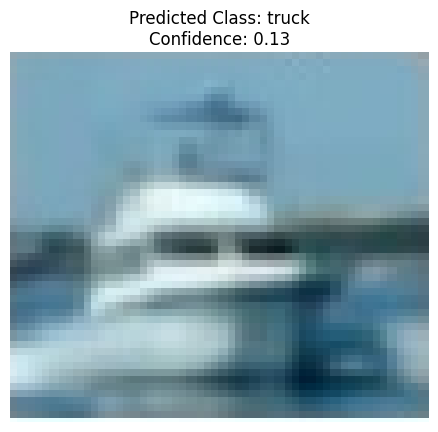

In [ ]:
image = cv2.imread("cifar_img1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)

with torch.no_grad():
    outputs = loaded_net(input_image)['logits']
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]


confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()

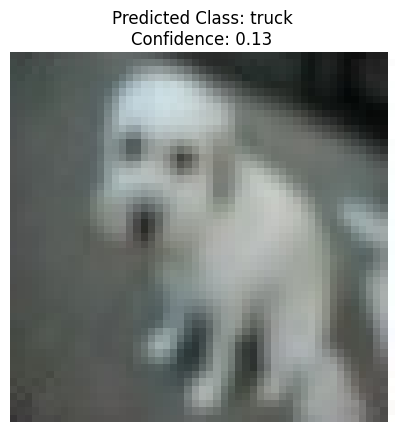

In [ ]:
image = cv2.imread("cifar_img2.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)

with torch.no_grad():
    outputs = loaded_net(input_image)['logits']
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]


confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()

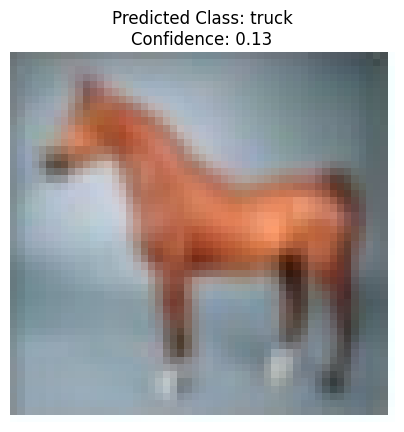

In [ ]:
image = cv2.imread("cifar_img3.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)

with torch.no_grad():
    outputs = loaded_net(input_image)['logits']
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]


confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()